In [ ]:
# 引入必要的库
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(32), # 从中心裁剪
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.465, 0.406], [0.229, 0.224, 0.225]),
])
train_data = dataset.SVHN(root='data',
                          split='train',
                          transform=transform,
                          download=False)
test_data = dataset.SVHN(root='data',
                         split='test',
                         transform=transform,
                         download=False)

X = train_data.data
print(X.shape)
randIndices=[np.random.randint(0,X.shape[0]) for i in range(1000)]
X=X[randIndices]
X=X.reshape(X.shape[0],-1)
y = train_data.labels
y=y[randIndices]
print(X.shape)
print(y.shape)
# 将标签二值化!!!
y = label_binarize(y, classes=[0, 1, 2,3,4,5,6,7,8,9])

n_classes = y.shape[1]
print(n_classes)

# 训练模型并预测
random_state = np.random.RandomState(0) # 伪随机数生成器
n_samples, n_features = X.shape
 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,random_state=0)
X_test=test_data.data
randIndices=[np.random.randint(0,X_test.shape[0]) for i in range(100)]
X_test=X_test[randIndices]
X_test=X_test.reshape(X_test.shape[0],-1)
y_test=test_data.labels
y_test=y_test[randIndices]
y_test = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9])

kernel_name = 'poly'
classifier = OneVsRestClassifier(svm.SVC(kernel=kernel_name, probability=True,random_state=random_state))#一对多 linear poly rbf sigmoid
y_score = classifier.fit(X, y).decision_function(X_test) #distance of each sample from the decision boundary for each class
print(kernel_name+' kernel accuracy in trainset: '+str(classifier.score(X,y))) # mean accuracy on the given test data and labels.
print(kernel_name+' kernel accuracy in trainset: '+str(classifier.score(X_test,y_test)))

(73257, 3, 32, 32)
(1000, 3072)
(1000,)
10


In [5]:
print(y_score.shape)
print(y_score[0])
y_pred=classifier.predict(X) #Predict multi-class targets using underlying estimators.
print(y_pred.shape)
print(y_pred[0])
y_pred_s=classifier.predict_proba(X)
print(y_pred_s.shape)
print(y_pred_s[0])
print(y.shape)
print(y[2])

(100, 10)
[-0.64694868 -1.39130221 -2.20133125 -1.41072293 -0.86120351 -1.41948115
 -0.4915411   0.44715289 -1.6065939  -0.57509268]
(1000, 10)
[0 0 1 0 0 0 0 0 0 0]
(1000, 10)
[0.06247154 0.16302324 0.41331196 0.0983352  0.0090951  0.05861389
 0.0253305  0.06023205 0.07714448 0.06405747]


(1000, 10)


In [15]:
# 计算每一类的ROC
fpr = dict() # 假正例率
tpr = dict() # 真正例率
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 
# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print(fpr)
print(tpr)
print(roc_auc)

{0: array([0.        , 0.01052632, 0.02105263, 0.02105263, 0.16842105,
       0.16842105, 0.29473684, 0.29473684, 0.87368421, 0.87368421,
       0.96842105, 0.96842105, 1.        ]), 1: array([0.        , 0.01190476, 0.03571429, 0.03571429, 0.04761905,
       0.04761905, 0.05952381, 0.05952381, 0.07142857, 0.07142857,
       0.08333333, 0.08333333, 0.22619048, 0.22619048, 0.23809524,
       0.23809524, 0.28571429, 0.28571429, 0.30952381, 0.30952381,
       0.33333333, 0.33333333, 0.3452381 , 0.3452381 , 0.36904762,
       0.36904762, 0.47619048, 0.47619048, 0.51190476, 0.51190476,
       0.5952381 , 0.5952381 , 1.        ]), 2: array([0.    , 0.    , 0.    , 0.0125, 0.0125, 0.0875, 0.0875, 0.1   ,
       0.1   , 0.1375, 0.1375, 0.15  , 0.15  , 0.1625, 0.1625, 0.2   ,
       0.2   , 0.3125, 0.3125, 0.475 , 0.475 , 0.55  , 0.55  , 1.    ]), 3: array([0.        , 0.01123596, 0.04494382, 0.04494382, 0.07865169,
       0.07865169, 0.08988764, 0.08988764, 0.12359551, 0.12359551,
       0.134

In [13]:
# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(all_fpr)
print(mean_tpr)
print(roc_auc)

[0.         0.01041667 0.01052632 0.01086957 0.01111111 0.01123596
 0.01162791 0.01190476 0.0125     0.02083333 0.02105263 0.02173913
 0.02222222 0.02325581 0.03488372 0.03571429 0.04347826 0.04494382
 0.04761905 0.05813953 0.05952381 0.06521739 0.06976744 0.07142857
 0.07291667 0.07608696 0.07777778 0.07865169 0.08139535 0.08333333
 0.0875     0.08988764 0.1        0.10465116 0.10869565 0.11627907
 0.11956522 0.12359551 0.13483146 0.13541667 0.1375     0.15
 0.15217391 0.1625     0.1627907  0.16842105 0.17777778 0.2
 0.20930233 0.22222222 0.22619048 0.22916667 0.23595506 0.23809524
 0.23913043 0.28571429 0.29473684 0.30952381 0.3125     0.33333333
 0.3452381  0.34883721 0.36904762 0.43333333 0.45833333 0.475
 0.47619048 0.5        0.51162791 0.51190476 0.51685393 0.55
 0.5505618  0.57608696 0.58695652 0.5952381  0.6875     0.75555556
 0.87368421 0.87640449 0.9        0.93333333 0.96842105 0.98876404
 1.        ]
[0.08714286 0.08714286 0.08714286 0.08714286 0.08714286 0.08714286
 0.094

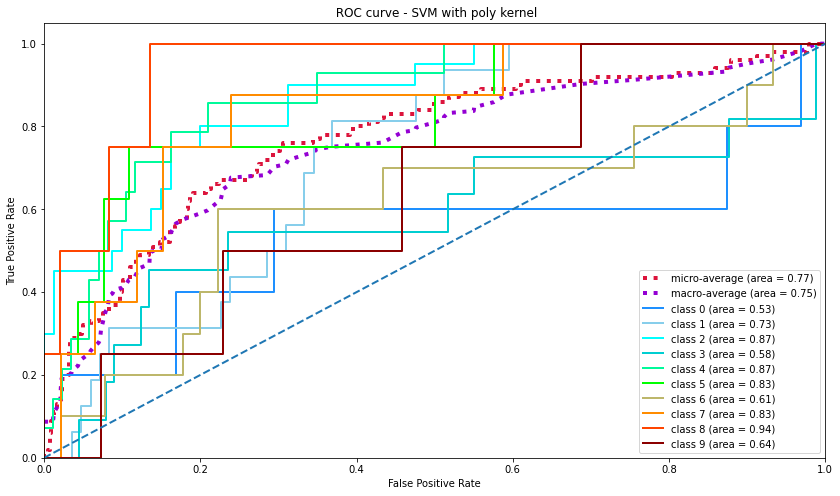

In [14]:
plt.rcParams['figure.figsize'] = (14,8) # 调整展示时的图片区域大小
# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='#DC143C', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='#9400D3', linestyle=':', linewidth=4)

colors = cycle(['#1E90FF', '#87CEEB', '#00FFFF','#00CED1','#00FA9A','#00FF00','#BDB76B','#FF8C00','#FF4500','#8B0000'])
for i, c in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=c, lw=lw,
             label='class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], '--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' ROC curve - SVM with '+kernel_name+' kernel')
plt.legend(loc="lower right")
# plt.show()
plt.savefig('out/svm_'+kernel_name+'.png')